In [1]:
%matplotlib inline
import pandas as pd
from os.path import join
import seaborn as sns
import numpy as np
from stats import mc_t_two_sample
import itertools
from IPython.display import SVG, display
import xml.etree.ElementTree as ET
ET.register_namespace("","http://www.w3.org/2000/svg")


/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


##Load the mapping file and add columns for each "swatch"


In [2]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == '16S']
sample_md = sample_md[sample_md['OfficeSample'] == 'yes']
sample_md['Meta'] = sample_md.Description.apply(lambda x: '.'.join(x.split('.')[:3]))
sample_md = sample_md.drop(['16SITS', 'BarcodeSequence', 'BlankExtraction'], axis=1)
sample_md['Swatch'] = sample_md['PlateLocation'].apply(lambda x: x.upper()[0]).values + '.' + sample_md['Row'].astype(str) + '.' + sample_md['Material'].apply(lambda x: x.title()[:2]).values

##Filter the replicate ID's

In [3]:
replicate_ids = '''F2F.2.Ce.021
F2F.2.Ce.022
F2F.3.Ce.021
F2F.3.Ce.022
F2W.2.Ca.021
F2W.2.Ca.022
F2W.2.Ce.021
F2W.2.Ce.022
F3W.2.Ce.021
F3W.2.Ce.022
F1F.3.Ca.021
F1F.3.Ca.022
F1C.3.Ca.021
F1C.3.Ca.022
F1W.2.Ce.021
F1W.2.Ce.022
F1W.3.Dr.021
F1W.3.Dr.022
F1C.3.Dr.021
F1C.3.Dr.022
F2W.3.Dr.059'''.split('\n')

In [4]:
reps = sample_md[sample_md['Description'].isin(replicate_ids)]
reps = reps.drop(reps.drop_duplicates('Description').index).index
sample_md = sample_md.drop(reps, inplace=False)

##Create map to svg
The svg was created with illustrator. Each surface of interest has a unique color so that we can map new colors to it

In [5]:
swatches = {'#1FFFFF':'F.3.Ca', '#2FFFFF':'F.3.Ce', '#3FFFFF':'F.3.Dr',
            '#4FFFFF':'F.2.Ca', '#5FFFFF':'F.2.Ce', '#6FFFFF':'F.2.Dr',
            '#7FFFFF':'W.3.Ca', '#8FFFFF':'W.3.Ce', '#9FFFFF':'W.3.Dr',
            '#10FFFF':'W.2.Ca', '#11FFFF':'W.2.Ce', '#12FFFF':'W.2.Dr',
            '#13FFFF':'C.3.Ca', '#14FFFF':'C.3.Ce', '#15FFFF':'C.3.Dr',
            '#16FFFF':'C.2.Ca', '#17FFFF':'C.2.Ce', '#18FFFF':'C.2.Dr'}

inv_swatches = {v: k for k, v in swatches.items()}
sample_md['SvgCols'] = sample_md.Swatch.map(inv_swatches)

##Add the alpha diversity metrics to the mapping file


In [6]:
alpha_div_fp = '/home/office-microbe-files/core_div_out/arare_max1000/alpha_div_collated/PD_whole_tree.txt'
alpha_div = pd.read_csv(alpha_div_fp, sep='\t', index_col=0)
alpha_div = alpha_div.T.drop(['sequences per sample', 'iteration'])
alpha_cols = [e for e in alpha_div.columns if '1000' in e]
alpha_div = alpha_div[alpha_cols]
sample_md = pd.concat([sample_md, alpha_div], axis=1, join='inner')
sample_md['MeanAlpha'] = sample_md[alpha_cols].mean(axis=1)
sample_md['MedianAlpha'] = sample_md[alpha_cols].median(axis=1)

##Define a function that will take map values to the svg

In [7]:
def color_plot(df, output):
    tree = ET.parse('office1.svg')
    root = tree.getroot()
    for child in root:
        if 'fill' in child.attrib:
            if child.attrib['fill'] in df.SvgCols.values:
                child.attrib['fill'] = df[df['SvgCols'] == child.attrib['fill']]['Colors'].values.astype(str)[0]
            elif child.attrib['fill'] in swatches.keys():
                child.attrib['fill'] = '#FFFFFF'
    tree.write(output)

#Map colors to the office SVG 

Illustrate what this will look like

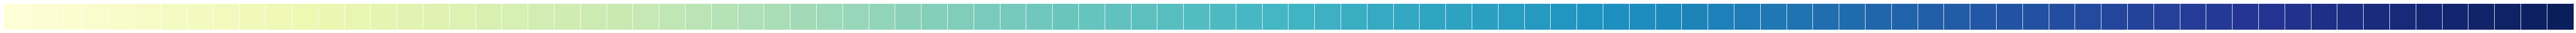

In [8]:
colors = sns.color_palette("YlGnBu", int(np.ceil(sample_md.MeanAlpha.max() - sample_md.MeanAlpha.min())))
sns.palplot(colors)

In [9]:
col_interest = 'MeanAlpha'

In [10]:
alpha_colors = sample_md[[col_interest, 'City', 'OfficeNumber', 'Description', 'Event', 'Swatch', 'SvgCols']]
alpha_colors = alpha_colors[(alpha_colors['City'] == 'sandiego') & 
             (alpha_colors['OfficeNumber'] == '1') & 
             (alpha_colors['Event'] == '70')]

alpha_colors = alpha_colors[alpha_colors[col_interest].notnull()]

In [11]:
colors = sns.color_palette("YlGnBu", int(np.ceil(alpha_colors[col_interest].max() - alpha_colors[col_interest].min())))
alpha_colors['Colors'] = [colors.as_hex()[int(e-alpha_colors[col_interest].min())] for e in alpha_colors[col_interest].values]

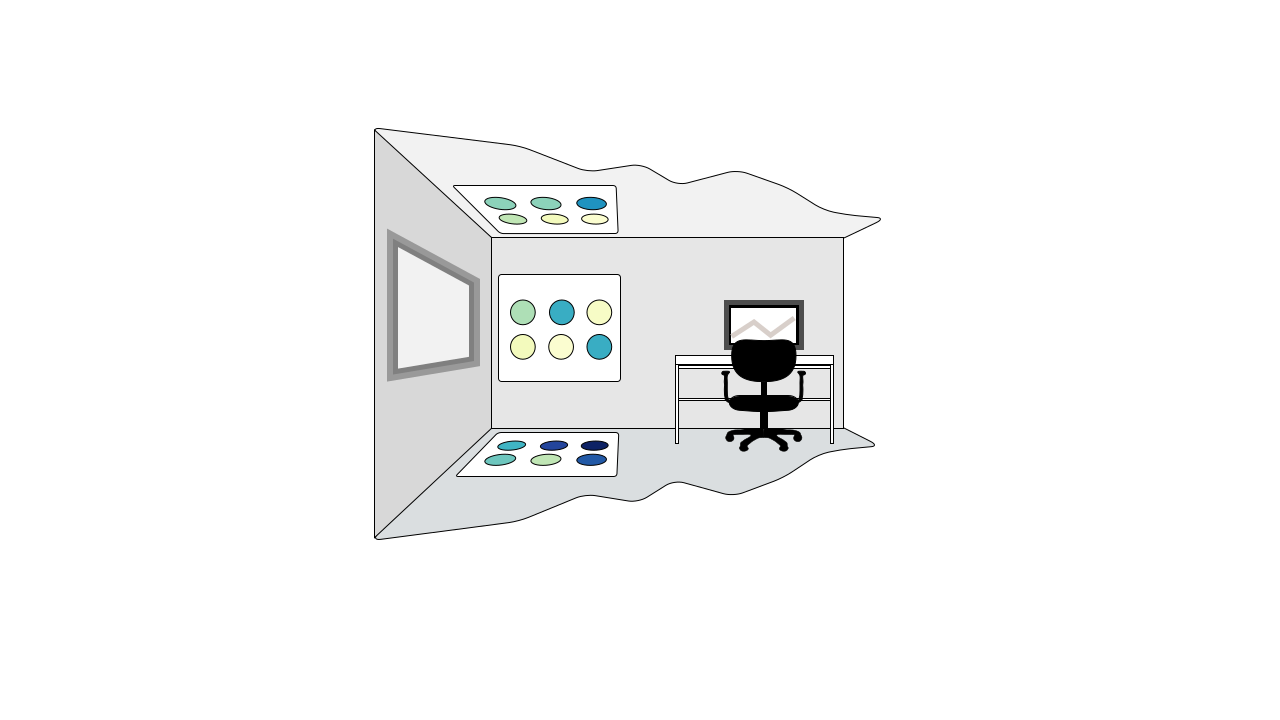

In [12]:
color_plot(alpha_colors, 'output.svg')
SVG(filename='output.svg')

##Create a figure for every season, city, office combination (12 total)

In [13]:
df_fig = sample_md.groupby(['City', 'Period', 'Swatch']).agg('median').reset_index()
df_fig['SvgCols'] = df_fig.Swatch.map(inv_swatches)

In [14]:
col_interest = 'MeanAlpha'
colors = sns.color_palette("YlGnBu", int(np.ceil(df_fig[col_interest].max() - df_fig[col_interest].min())))
df_fig['Colors'] = [colors.as_hex()[int(e-df_fig[col_interest].min())] for e in df_fig[col_interest].values]

In [15]:
for city in df_fig.City.unique():
    for period in df_fig.Period.unique():
        color_plot(df_fig[(df_fig['City'] == city) & (df_fig['Period'] == period)], '{0}_{1}.svg'.format(city, period))

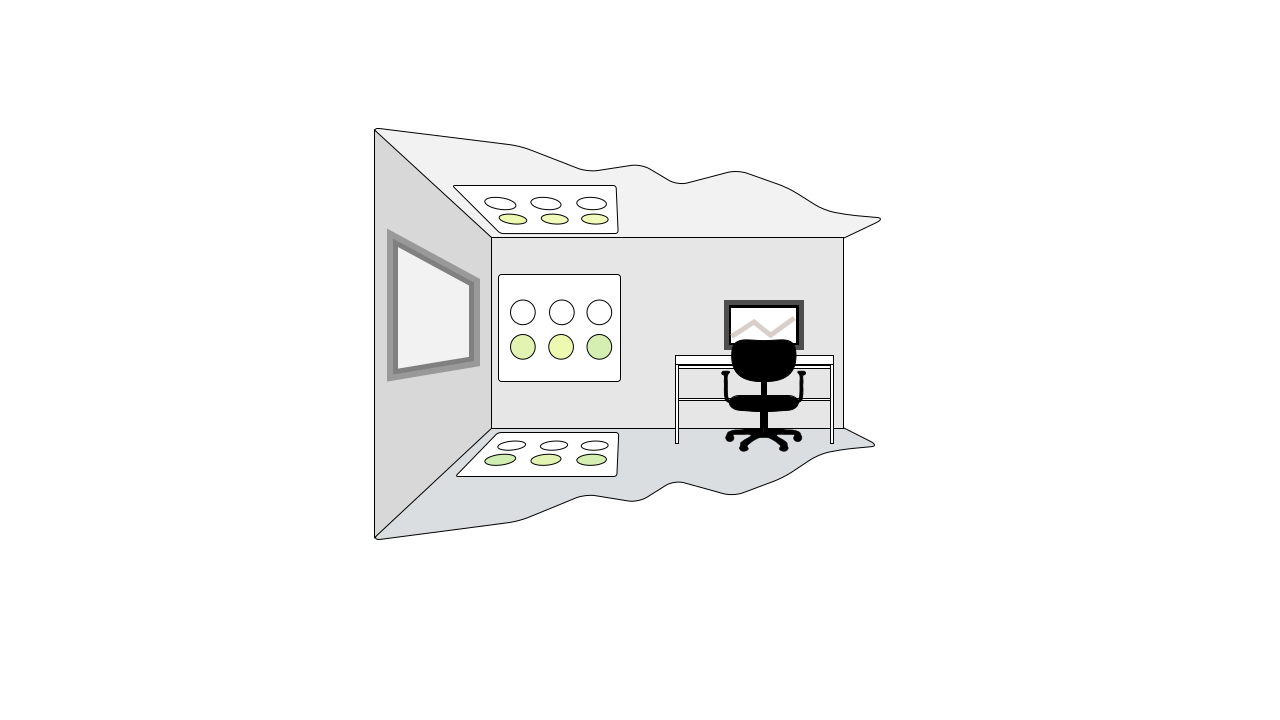

In [16]:
SVG(filename='toronto_1.svg')

##Alpha Diversity statistics

##Get statisitics for period 1 vs all other periods for all cities

negative values in the following statistics indicate that that the period on the left is less diverse than the period on the right

In [ ]:
for city in sample_md.City.unique():
    for period1, period2 in itertools.combinations(sample_md.Period.unique(), 2):
        per_1 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period1)]['MeanAlpha'].values) 
        per_2 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period2)]['MeanAlpha'].values)
        obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
        print('City {0} Period {1}-Period {2} t-stat: {3} p-value: {4} n=({5}, {6})'.format(city, 
                                                                                            period1, 
                                                                                            period2, 
                                                                                            obs_t, 
                                                                                            param_p_val, 
                                                                                            len(per_1),
                                                                                            len(per_2)))
    print('\n')

City flagstaff Period 1-Period 3 t-stat: -5.3921848193025745 p-value: 1.2529272711768162e-07 n=(230, 137)
City flagstaff Period 1-Period 2 t-stat: -3.1684160036776112 p-value: 0.0016713337225163151 n=(230, 113)
City flagstaff Period 1-Period 4 t-stat: -0.25019351537900103 p-value: 0.8025701196654533 n=(230, 160)
City flagstaff Period 3-Period 2 t-stat: 1.4883045997054063 p-value: 0.13794102677082898 n=(137, 113)
City flagstaff Period 3-Period 4 t-stat: 3.880661275245035 p-value: 0.00012854679900886623 n=(137, 160)
City flagstaff Period 2-Period 4 t-stat: 2.188891509761301 p-value: 0.029458065919180987 n=(113, 160)


City sandiego Period 1-Period 3 t-stat: -7.9060762878411746 p-value: 4.7800646705579597e-14 n=(194, 116)
City sandiego Period 1-Period 2 t-stat: -11.020648353688685 p-value: 7.995686451708489e-24 n=(194, 98)
City sandiego Period 1-Period 4 t-stat: -4.84029089462673 p-value: 1.8533977652925293e-06 n=(194, 209)
City sandiego Period 3-Period 2 t-stat: -1.9603822231506167 p-val

In [ ]:
for period in sample_md.Period.unique():
    for city1, city2 in itertools.combinations(sample_md.City.unique(), 2):
        per_1 = list(sample_md[(sample_md['City'] == city1) & (sample_md['Period'] == period)]['MeanAlpha'].values) 
        per_2 = list(sample_md[(sample_md['City'] == city2) & (sample_md['Period'] == period)]['MeanAlpha'].values)
        obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
        print('Period {0} {1}-{2} t-stat: {3} p-value: {4} n=({5}, {6})'.format(period, 
                                                                              city1, 
                                                                              city2, 
                                                                              obs_t, 
                                                                              param_p_val, 
                                                                              len(per_1),
                                                                              len(per_2)))
    print('\n')

Period 1 flagstaff-sandiego t-stat: 8.682625965722735 p-value: 2.220446049250313e-16 n=(230, 194)
Period 1 flagstaff-toronto t-stat: 8.356006761491841 p-value: 1.1102230246251565e-15 n=(230, 164)
Period 1 sandiego-toronto t-stat: -0.18791861155268683 p-value: 0.8510475175045024 n=(194, 164)

In [ ]:
for period in sample_md.Period.unique():
    for city in sample_md.City.unique():
        for loc1, loc2 in itertools.combinations(sample_md.PlateLocation.unique(), 2):
            per_1 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['PlateLocation'] == loc1)]['MeanAlpha'].values) 
            per_2 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['PlateLocation'] == loc2)]['MeanAlpha'].values)
            obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
            print('Period {0}, City {1} {2}-{3} t-stat: {4} p-value: {5} n=({6}, {7})'.format(period, 
                                                                                              city, 
                                                                                              loc1, 
                                                                                              loc2,
                                                                                              obs_t,
                                                                                              param_p_val, 
                                                                                              len(per_1),
                                                                                              len(per_2)))
        print('\n')
    print('\n')

In [ ]:
for period in sample_md.Period.unique():
    for city in sample_md.City.unique():
        for loc1, loc2 in itertools.combinations(sample_md.Row.unique(), 2):
            per_1 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['Row'] == loc1)]['MeanAlpha'].values) 
            per_2 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['Row'] == loc2)]['MeanAlpha'].values)
            try:
                obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
                print('Period {0}, City {1} {2}-{3} t-stat: {4} p-value: {5} n=({6}, {7})'.format(period, 
                                                                                                  city, 
                                                                                                  loc1, 
                                                                                                  loc2,
                                                                                                  obs_t,
                                                                                                  param_p_val, 
                                                                                                  len(per_1),
                                                                                                  len(per_2)))
            except ValueError:
                print('not enough data')
    print('\n')

In [ ]:
for period in sample_md.Period.unique():
    for city in sample_md.City.unique():
        for loc1, loc2 in itertools.combinations(sample_md.Material.unique(), 2):
            per_1 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['Material'] == loc1)]['MeanAlpha'].values) 
            per_2 = list(sample_md[(sample_md['City'] == city) & (sample_md['Period'] == period) & (sample_md['Material'] == loc2)]['MeanAlpha'].values)
            obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(per_1, per_2)
            print('Period {0}, City {1} {2}-{3} t-stat: {4} p-value: {5} n=({6}, {7})'.format(period, 
                                                                                              city, 
                                                                                              loc1, 
                                                                                              loc2,
                                                                                              obs_t,
                                                                                              param_p_val, 
                                                                                              len(per_1),
                                                                                              len(per_2)))
        print('\n')
    print('\n')

In [ ]:
flagstaff = sample_md[sample_md['City'] == 'flagstaff']['MeanAlpha']
sandiego = sample_md[sample_md['City'] == 'sandiego']['MeanAlpha']
toronto = sample_md[sample_md['City'] == 'toronto']['MeanAlpha']

In [ ]:
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(flagstaff, sandiego)
print(obs_t, param_p_val)

In [ ]:
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(flagstaff, toronto)
print(obs_t, param_p_val)

In [ ]:
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(sandiego, toronto)
print(obs_t, param_p_val)